# Исследование поведения пользователей приложения по продаже продуктов питания. 


Субъект исследования -  стартап, который продаёт продукты питания. Требуется разобраться, как ведут себя пользователи мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах, на каких именно.
Исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

*В случае общей аналитики и A/A/B-эксперимента работаем с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Цель исследования:** Разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания. 

**Содержание**
    
    
1. [Изучение и предобработка данных из файла](#open)
        
    
2. [Исследовательский анализ данных](#pred)


3. [Изучение воронки событий](#portr)


4. [Изучение результатов эксперимента](#exp)


5. [Общий вывод](#summary)

<a id="open"></a>
## 1. Изучение и предобработка данных из файла

**Описание данных:**

Каждая запись в логе — это действие пользователя или событие.

Таблица logs_exp

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


Импортируем библиотеки

In [1]:
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
from statsmodels.stats.multitest import multipletests

# import requests
# from bs4 import BeautifulSoup
# import requests, io, urllib.request

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None

# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

In [2]:
# Изучаем таблицу

path = '/datasets/logs_exp.csv'
df = pd.read_csv(path, sep='\t')

display(df.head(10))
df.tail(10)
df.sample(5)
display(df.describe().T)
df.info()
print(df['EventName'].unique())
print(df['ExpId'].unique())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


,count,mean,std,min,25%,50%,75%,max
DeviceIDHash,"244,126.00","4,627,568,124,591,259,648.00","2,642,424,998,963,961,856.00","6,888,746,892,508,752.00","2,372,212,476,992,240,640.00","4,623,191,541,214,045,184.00","6,932,517,045,703,054,336.00","9,222,603,179,720,523,776.00"
EventTimestamp,"244,126.00","1,564,913,915.84","177,134.32","1,564,029,816.00","1,564,756,580.25","1,564,919,395.00","1,565,074,511.00","1,565,212,517.00"
ExpId,"244,126.00",247.02,0.82,246.00,246.00,247.00,248.00,248.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
[246 248 247]


Преобразуем временные типы данных в новых колонках

In [3]:
df['date_time'] = pd.to_datetime(df['EventTimestamp'], unit = 's')
df['date'] = df['date_time'].dt.strftime('%Y-%m-%d')
df.tail()

,EventName,DeviceIDHash,EventTimestamp,ExpId,date_time,date
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
244125,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07


Понизим битность некторых данных в целях экономии памяти

In [4]:
df['ExpId'] = df['ExpId'].astype('Int16') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       244126 non-null  object        
 1   DeviceIDHash    244126 non-null  int64         
 2   EventTimestamp  244126 non-null  int64         
 3   ExpId           244126 non-null  Int16         
 4   date_time       244126 non-null  datetime64[ns]
 5   date            244126 non-null  object        
dtypes: Int16(1), datetime64[ns](1), int64(2), object(2)
memory usage: 10.0+ MB


Изменим названия колонок в соответствии со "змеиным" стилем.

In [5]:
columns = ['event_name', 'user_id', 'event_time', 'exp_id', 'date_time', 'date']
df.set_axis(columns, axis = 'columns', inplace = True)
df.sample()

,event_name,user_id,event_time,exp_id,date_time,date
25971,MainScreenAppear,1038180862674591265,1564672362,248,2019-08-01 15:12:42,2019-08-01


Проверим данные на полные дубликаты и обработаем их

In [6]:
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)

413


### Вывод

* Данные были открыты и изучены. 
* Названия колонок приведены к единому стилю. 
* Пропусков в значениях не обнаружено. 
* Типы данных приведены к корректным
* Добавлены дополнительны колонки дл дальнейшего исследования. 
* Дубликаты в данных удалены.

<a id="pred"></a>
## 2. Исследовательский анализ данных

Выясним, Сколько всего событий в логе.

In [7]:
print(df['event_name'].unique())
df['event_name'].count()

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


243713

Всего в логе 243713 события 4х типов.

Узнаем сколько всего пользователей в логе.

In [8]:
print('Уникальных пользователей в логе:',len(df['user_id'].unique()))

Уникальных пользователей в логе: 7551


Выясним сколько в среднем событий приходится на пользователя.

In [9]:
print('Среднее количество событий на одного пользователя:', int(round(df['event_name'].count()/len(df['user_id'].unique()), 0)))
 

Среднее количество событий на одного пользователя: 32


Исследуем, данными за какой период мы располагаеем.

Период данных в логе: 14 дней


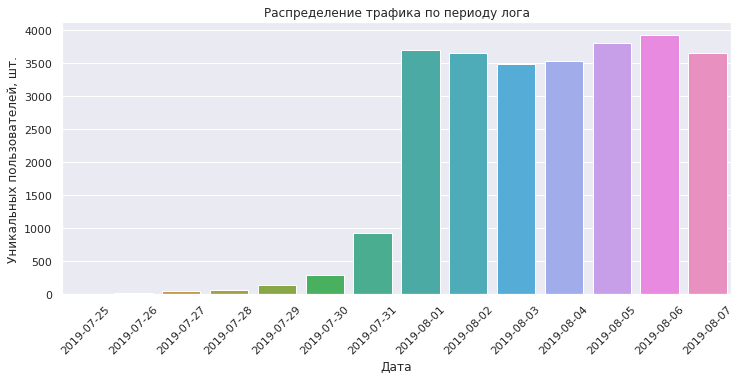

In [47]:
print('Период данных в логе:',len(df['date'].unique()), 'дней')

traffic = df.groupby('date').agg({'user_id': 'nunique'}).reset_index()
traffic.columns = ['date', 'uniq']
# display(traffic)

# Построим график по дням
bar = sb.barplot(y='uniq', x='date',  data=traffic)
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Дата', ylabel='Уникальных пользователей, шт.', title='Распределение трафика по периоду лога')
plt.xticks(rotation=45)
plt.show()

Полные данные прослеживаются только за период с 1 по 7 августа включительно. Отбросим периоды, по которым набор данных неполный.

In [11]:
df_good = df[df['date'] > '2019-07-31'].reset_index(drop=True)
display(df_good.head(10))
df_good.info()

,event_name,user_id,event_time,exp_id,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
5,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
6,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01
7,MainScreenAppear,3737462046622621720,1564618247,246,2019-08-01 00:10:47,2019-08-01
8,MainScreenAppear,3737462046622621720,1564618270,246,2019-08-01 00:11:10,2019-08-01
9,MainScreenAppear,3737462046622621720,1564618280,246,2019-08-01 00:11:20,2019-08-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240887 entries, 0 to 240886
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   event_time  240887 non-null  int64         
 3   exp_id      240887 non-null  Int16         
 4   date_time   240887 non-null  datetime64[ns]
 5   date        240887 non-null  object        
dtypes: Int16(1), datetime64[ns](1), int64(2), object(2)
memory usage: 9.9+ MB


Посмотрим много ли событий и пользователей мы потеряли, отбросив старые данные.

In [12]:
print('Осталось уникальных посетителей:',len(df_good['user_id'].unique()))
print('Осталось событий:',df_good['user_id'].count())
users_now = 100 - len(df_good['user_id'].unique()) / len(df['user_id'].unique()) * 100
events_now = 100 - df_good['user_id'].count() / df['user_id'].count() * 100
print('Потеряно пользователей после фильтрации: {}%'.format(round(users_now,2)) )
print('Потеряно событий после фильтрации: {}%'.format(round(events_now,2)) )

Осталось уникальных посетителей: 7534
Осталось событий: 240887
Потеряно пользователей после фильтрации: 0.23%
Потеряно событий после фильтрации: 1.16%


Потери небольшие, фильтрация лога оправдана.

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [13]:
len(df_good['exp_id'].unique())

3

Все три экспериментальные группы остались в отфильтрованном логе.

### Вывод

* Посчитано кол-во событий, пользователей и их отношение в среднем в логе.
* Определен период времени в логе, данные отфильтрованы по периоду с полными сведениями
* Определены потери от фильтрации, они незначительные, все группы экспериментов сохранены.

<a id="portr"></a>
## 3. Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [14]:
df_good['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

В логе шесть типов событий: "Обучение", "Переход на главный экран", "Экран выбора товара", "Экран корзины", "Экран оплаты".

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 

,event_name,count,nunique
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


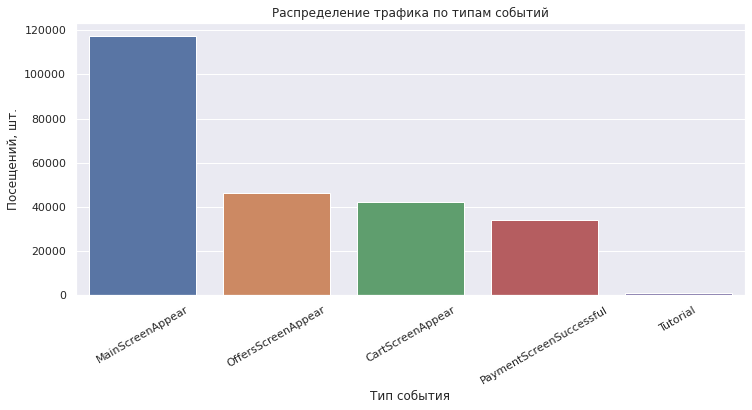

In [15]:
event_users = (df_good
               .groupby(['event_name'])['user_id'].agg(['count','nunique'])
               .sort_values(by='nunique', ascending=False)
               .reset_index()
              )
event_users.columns = ['event_name', 'count', 'nunique']
display(event_users)

# Построим график по дням
bar = sb.barplot(y='count', x='event_name',  data=event_users)
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Тип события', ylabel='Посещений, шт.', title='Распределение трафика по типам событий')
plt.xticks(rotation=30)
plt.show()

Главная страница лидирует с большим отрывом. Затем идет экран выбора товаров, далее экран корзины, и наконец, экран успешной оплаты. Почти никто не использует обучение.
Посчитаем долю пользователей, которые хоть раз совершали событие.

In [16]:
event_users['rate'] = (event_users['nunique'] / len(df_good['user_id'].unique()) * 100).round(1)
event_users

,event_name,count,nunique,rate
0,MainScreenAppear,117328,7419,98.50
1,OffersScreenAppear,46333,4593,61.00
2,CartScreenAppear,42303,3734,49.60
3,PaymentScreenSuccessful,33918,3539,47.00
4,Tutorial,1005,840,11.10


98% посетителей приложения хоть раз его запускали. 61 % пользователей добрался до страницы выбора заказов. До корзины добралось  меньше половины пользователей, 47 % успешно оплатили заказ и 11 % попытались пройти обучение.

События происходят в следующем порядке:

* Переход на главный экран;
* Экран выбора товара;
* Экран корзины;
* Экран успешной оплаты.
* Обучение (факультативно);

Экран обучения в последовательной логической цепочке лишний, так как его посещение не влияет на переход к другим событиям.
Отсеим данное событие из лога.

In [17]:
event_users = event_users[event_users['event_name'] != 'Tutorial']
display(event_users)

,event_name,count,nunique,rate
0,MainScreenAppear,117328,7419,98.50
1,OffersScreenAppear,46333,4593,61.00
2,CartScreenAppear,42303,3734,49.60
3,PaymentScreenSuccessful,33918,3539,47.00


Посчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [18]:
event_users['ratio'] = ''

def ratio(row):
    event_users.loc[0, 'ratio'] = 100
    for i in [0, 1, 2]:
        ratio = ((event_users.loc[(i+1), 'nunique'] / event_users.loc[i, 'nunique']) * 100).round(1)
        event_users.loc[(i+1), 'ratio'] = ratio
    return row

event_users = event_users.apply(ratio)
display(event_users)

,event_name,count,nunique,rate,ratio
0,MainScreenAppear,117328,7419,98.50,100
1,OffersScreenAppear,46333,4593,61.00,61.90
2,CartScreenAppear,42303,3734,49.60,81.30
3,PaymentScreenSuccessful,33918,3539,47.00,94.80


Больше всего пользователей отсеивается на первом шаге - только 61,9 % пользователей запустивших приложение перешли к заказам. Среди последующих шагов потери замедляются. Почти 95% посетителей набравших корзину оплатили заказ.

Определим какая доля пользователей доходит от первого события до оплаты, вычислив коэффициент удержания.

In [19]:
event_users['retention_rate'] = ''

def retention_rate(row):
    event_users.loc[0, 'retention_rate'] = 100
    for i in [0, 1, 2]:
        retention_rate = ((event_users.loc[(i+1), 'nunique'] / event_users.loc[0, 'nunique']) * 100).round(1)
        event_users.loc[(i+1), 'retention_rate'] = retention_rate
    return row

event_users = event_users.apply(retention_rate)
display(event_users)

,event_name,count,nunique,rate,ratio,retention_rate
0,MainScreenAppear,117328,7419,98.50,100,100
1,OffersScreenAppear,46333,4593,61.00,61.90,61.90
2,CartScreenAppear,42303,3734,49.60,81.30,50.30
3,PaymentScreenSuccessful,33918,3539,47.00,94.80,47.70


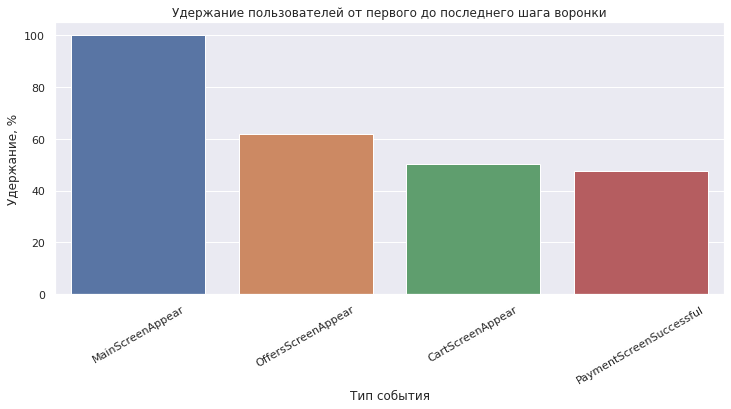

In [20]:
bar = sb.barplot(y='retention_rate', x='event_name',  data=event_users)
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Тип события', ylabel='Удержание, %', title='Удержание пользователей от первого до последнего шага воронки')
plt.xticks(rotation=30)
plt.show()

До оплаты заказа добирается около 48% посетителей. По графику видно, что удержание на втором шаге самое незначительное. 

### Вывод

* Исследованы разные типы событий в логах по общим и уникальным посетителям
* Выявлена закономерность и лишнее звено в последовательности событий лога
* Исследовано поведение пользователей от первого до последнего шага воронки

<a id="exp"></a>
## 4. Изучение результатов эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе

In [21]:
users_group = df_good.groupby(['exp_id'])['user_id'].agg('nunique').reset_index()
display(users_group)

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


Во всех группах эксперимента сопоставимое количество уникальных пользователей. Разница составляет не более 1%.

Проверим пользователей на пересечения в группах

In [22]:
# Выделим группы в переменные
group_a = df_good[df_good['exp_id'] == 246]['user_id'].unique()
group_b = df_good[df_good['exp_id'] == 247]['user_id'].unique()
group_c = df_good[df_good['exp_id'] == 248]['user_id'].unique()

In [23]:
# Найдем пересечения
a_b = []
a_c = []
b_c = []
for item in group_a:
    if item in group_b:
        a_b.append(item)
    if item in group_c:
        a_c.append(item)
for item in group_b:
    if item in group_c:
        b_c.append(item)
        
print(a_b)
print(a_c)
print(b_c)

[]
[]
[]


Пересечений не обнаружено, можно продолжать исследование. Соберем датафрэймы по разным группам.

In [24]:
# Соберем датафрэйм по группе 246
event_users_a = (df_good.query('exp_id == 246 and event_name != "Tutorial"')
               .groupby(['event_name'])['user_id'].agg(['count','nunique'])
               .sort_values(by='nunique', ascending=False)
               .reset_index()
              )
event_users_a.columns = ['event_name', 'count', 'nunique']

# Добавим коэфициент удержания
event_users_a['retention_rate'] = ''
event_users_a.loc[0, 'retention_rate'] = 100
for i in [0, 1, 2]:
    retention_rate = ((event_users_a.loc[(i+1), 'nunique'] / event_users_a.loc[0, 'nunique']) * 100).round(1)   
    event_users_a.loc[(i+1), 'retention_rate'] = retention_rate

# Добавим поле с общим кол-вом пользователейв группе
event_users_a['total'] = users_group['user_id'][0]

display(event_users_a)

,event_name,count,nunique,retention_rate,total
0,MainScreenAppear,37676,2450,100,2484
1,OffersScreenAppear,14767,1542,62.90,2484
2,CartScreenAppear,14690,1266,51.70,2484
3,PaymentScreenSuccessful,11852,1200,49.00,2484


In [25]:
# Аналогично по группе 247
event_users_b = (df_good.query('exp_id == 247 and event_name != "Tutorial"')
               .groupby(['event_name'])['user_id'].agg(['count','nunique'])
               .sort_values(by='nunique', ascending=False)
               .reset_index()
              )
event_users_b.columns = ['event_name', 'count', 'nunique']

# Добавим коэфициент удержания
event_users_b['retention_rate'] = ''
event_users_b.loc[0, 'retention_rate'] = 100
for i in [0, 1, 2]:
    retention_rate = ((event_users_b.loc[(i+1), 'nunique'] / event_users_b.loc[0, 'nunique']) * 100).round(1)
    event_users_b.loc[(i+1), 'retention_rate'] = retention_rate

# Добавим поле с общим кол-вом пользователейв группе
event_users_b['total'] = users_group['user_id'][1]

display(event_users_b)

,event_name,count,nunique,retention_rate,total
0,MainScreenAppear,39090,2476,100,2513
1,OffersScreenAppear,15179,1520,61.40,2513
2,CartScreenAppear,12434,1238,50.00,2513
3,PaymentScreenSuccessful,9981,1158,46.80,2513


In [26]:
# И по группе 248
event_users_c = (df_good.query('exp_id == 248 and event_name != "Tutorial"')
               .groupby(['event_name'])['user_id'].agg(['count','nunique'])
               .sort_values(by='nunique', ascending=False)
               .reset_index()
              )
event_users_c.columns = ['event_name', 'count', 'nunique']

# Добавим коэфициент удержания
event_users_c['retention_rate'] = ''
event_users_c.loc[0, 'retention_rate'] = 100
for i in [0, 1, 2]:
    retention_rate = ((event_users_c.loc[(i+1), 'nunique'] / event_users_c.loc[0, 'nunique']) * 100).round(1)
    event_users_c.loc[(i+1), 'retention_rate'] = retention_rate

# Добавим поле с общим кол-вом пользователейв группе
event_users_c['total'] = users_group['user_id'][2]

display(event_users_c)

,event_name,count,nunique,retention_rate,total
0,MainScreenAppear,40562,2493,100,2537
1,OffersScreenAppear,16387,1531,61.40,2537
2,CartScreenAppear,15179,1230,49.30,2537
3,PaymentScreenSuccessful,12085,1181,47.40,2537


Нам необходимо проверить гипотезы о статистической разнице долей в самом популярном и в остальных событиях между выборками 246 и 247 (группы a и b) по результатам A/A теста.

Затем необходимо проверить гипотезы о статистической разнице долей в самом популярном и в остальных событиях между выборками 246 и 248 (группы a и c), а также между выборками 247 и 248 (группы b и c) по результатам A/B теста.

Затем необходимо проверить гипотезы о статистической разнице долей в самом популярном и в остальных событиях между объединенной выборкой 246+247 и 248 (группы a+b и c) по результатам A/B теста.

In [27]:
# Определим функцию для z-теста проверки стат разницы между группами по событиям
def z_test(event_number, table1, table2):
    successes = np.array([table1.loc[event_number, 'nunique'], table2.loc[event_number, 'nunique']])
    trials = np.array([table1.loc[0, 'total'], table2.loc[0, 'total']])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [28]:
# Зададим уровень значимости и распределение
distr = st.norm(0, 1)

alpha = 0.05
# СКОРРЕКТИРОВАННЫЙ УРОВЕНЬ ЗНАЧИМОСТИ
# alpha = 0.003


Проверим, есть ли статистически значимая разница между выборками 246 и 247 (контрольные группы для А/А-эксперимента), с помощью z-теста.

Нулевая гипотеза: доли пользователей, добравшихся до успешной оплаты в группах А\А теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до успешной оплаты из групп А\А теста есть статистически значимая разница.

In [29]:
z_test (3, event_users_a, event_users_b)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Самым популярным событием является открытие главной страницы. Проверим, будет ли отличие между группами статистически достоверным. 

Нулевая гипотеза: доли пользователей, добравшихся до главной страницы в группах А\А теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до главной страницы из групп А\А теста есть статистически значимая разница.

In [30]:
z_test (0, event_users_a, event_users_b)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проделаем то же самое для всех других событий.

Тест по событию перехода на страницу выбора товаров для групп A\A теста

Нулевая гипотеза: доли пользователей, добравшихся до страницы выбора товаров в группах А\А теста одинаковы. 

Гипотеза Н1: между долями 
пользователей, добравшихся до страницы выбора товаров в группах А\А теста есть статистически значимая разница.

In [31]:
z_test(1, event_users_a, event_users_b)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Тест по событию перехода на страницу корзины для групп A\A теста

Нулевая гипотеза: доли пользователей, добравшихся до страницы корзины в группах А\А теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до страницы корзины в группах А\А теста есть статистически значимая разница.

In [32]:
z_test(2, event_users_a, event_users_b)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: настройку теста для всех событий можно считать корректной: разбиение на группы работает должным образом, статистической разницы между группами A/A теста нет ни по одному из событий.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 

Событие перехода на главную страницу для групп А и С

Нулевая гипотеза: доли пользователей, добравшихся до главной страницы в группах А\B теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до главной страницы в группах А\B теста есть статистически значимая разница.

In [33]:
z_test(0, event_users_a, event_users_c)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [34]:
z_test(0, event_users_b, event_users_c)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие перехода на страницу выбора товаров для групп А\B теста

Нулевая гипотеза: доли пользователей, добравшихся до страницы выбора товаров в группах А\B теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до страницы выбора товаров в группах А\B теста есть статистически значимая разница.

In [35]:
z_test(1, event_users_a, event_users_c)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
z_test(1, event_users_b, event_users_c)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие перехода на страницу корзины для групп А\B теста

Нулевая гипотеза: доли пользователей, добравшихся до страницы корзины в группах А\B теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до страницы корзины в группах А\B теста есть статистически значимая разница.

In [37]:
z_test(2, event_users_a, event_users_c)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
z_test(2, event_users_b, event_users_c)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие перехода на страницу успешной оплаты для групп А\B теста

Нулевая гипотеза: доли пользователей, добравшихся до страницы успешной оплаты в группах А\B теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до страницы успешной оплаты в группах А\B теста есть статистически значимая разница.

In [39]:
z_test(3, event_users_a, event_users_c)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
z_test(3, event_users_b, event_users_c)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Судя по всему, новый шрифт никак не повлиял на поведение пользователей. Сравним результаты с объединённой контрольной группой.

In [41]:
# Соберем датафрэйм по объединенной группе
event_users_ab = (df_good.query('exp_id != 248 and event_name != "Tutorial"')
               .groupby(['event_name'])['user_id'].agg(['count','nunique'])
               .sort_values(by='nunique', ascending=False)
               .reset_index()
              )
event_users_ab.columns = ['event_name', 'count', 'nunique']

# Добавим коэфициент удержания
event_users_ab['retention_rate'] = ''
event_users_ab.loc[0, 'retention_rate'] = 100
for i in [0, 1, 2]:
    retention_rate = ((event_users_ab.loc[(i+1), 'nunique'] / event_users_ab.loc[0, 'nunique']) * 100).round(1)
    event_users_ab.loc[(i+1), 'retention_rate'] = retention_rate

# Добавим поле с общим кол-вом пользователей в группе
event_users_ab['total'] = users_group['user_id'][1] + users_group['user_id'][2]

display(event_users_ab)

,event_name,count,nunique,retention_rate,total
0,MainScreenAppear,76766,4926,100,5050
1,OffersScreenAppear,29946,3062,62.20,5050
2,CartScreenAppear,27124,2504,50.80,5050
3,PaymentScreenSuccessful,21833,2358,47.90,5050


Событие перехода на главную страницу для групп АB и С

Нулевая гипотеза: доли пользователей, добравшихся до главной страницы в группах АB и С одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до главной страницы в группах АB и С теста есть статистически значимая разница.

In [42]:
z_test(0, event_users_ab, event_users_c)

p-значение:  0.044030037938398214
Отвергаем нулевую гипотезу: между долями есть значимая разница


При сравнении с объединенной контрольной группой статистическая разница есть в событии главной страницы.

Событие перехода на главную страницу выбора товаров для групп АB и С

Нулевая гипотеза: доли пользователей, добравшихся до страницы выбора товаров в группах АB и С одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся до страницы выбора товаров в группах АB и С теста есть статистически значимая разница.

In [43]:
z_test(1, event_users_ab, event_users_c)

p-значение:  0.8094585855008445
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие перехода на страницу корзины для групп АB и С

Нулевая гипотеза: доли пользователей, добравшихся на страницу корзины в группах АB и С теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся на страницу корзины в группах АB и С теста есть статистически значимая разница.

In [44]:
z_test(2, event_users_ab, event_users_c)

p-значение:  0.3651688372070827
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Событие перехода на страницу успешной оплаты для групп АB и С

Нулевая гипотеза: доли пользователей, добравшихся на страницу успешной оплаты в группах АB и С теста одинаковы.

Гипотеза Н1: между долями пользователей, добравшихся на страницу успешной оплаты в группах АB и С теста есть статистически значимая разница.

In [45]:
z_test(3, event_users_ab, event_users_c)

p-значение:  0.9068688801650748
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Поскольку мы проводим множественный тест, т.е. берем несколько выборок из одного и того же набора данных -с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. В связи с этим мы должны скорректировать уровень значимости alpha (хотя лишь по одному из проведенных сравнений обнаружилось значимое различие). 

Выберем метод Шидака. При проверке результатов A/B теста мы сравнивали 4 сочетания групп А1А2, А1В, А2В, А1+А2/В и 4 конверсии (без tutorial). Получается 4*4 = 16. Соответственно формула для расчета уровня значимости будет такой:

In [46]:
print(round(1 - (1 - 0.05)**(1/16),3))

0.003


Пересчитаем результаты. Результат изменился в выводе по статистической разнице при сравнении с объединенной контрольной группой в событии главной страницы. Соответственно нет оснований считать что есть статзначимая разница между экспериментами на всех событиях.

### Вывод

Статистически значимой разницы между долями в группах старым и новым шрифтами нет. 

p-value для события успешного заказа:
* в группах А и С: 0.21 
* в группах В и С: 0.74
* для объединенной группы АВ и С: 0.91
* была выявлена статистическая разница при сравнении с объединенной контрольной группой в событии главной страницы. (но только на уровне значимости без корректировки на ошибки)
* после корректировки уровня значимости послений вывод изменился на противоположный.

<a id="summary"></a>
## 5. Общий вывод

Данные лога были открыты и изучены. Была проведена предобработка данных:

* Названия колонок приведены к единому стилю.
* Пропусков в значениях не обнаружено.
* Типы данных приведены к корректным
* Добавлены дополнительны колонки дл дальнейшего исследования.
* Дубликаты в данных удалены.

Проведен исследовательский анализ:

* Посчитано кол-во событий, пользователей и их отношение в среднем в логе.
* Определен период времени в логе, данные отфильтрованы по периоду с полными сведениями
* Определены потери от фильтрации, они незначительные, все группы экспериментов сохранены.

Изучена воронка событий:

* Исследованы разные типы событий в логах по общим и уникальным посетителям
* Выявлена закономерность и лишнее звено в последовательности событий лога
* Исследовано поведение пользователей от первого до последнего шага воронки

Проанализированы результаты эксперимента:
Статистически значимой разницы между долями в группах старым и новым шрифтами нет.

p-value для события успешного заказа:
* в группах А и С: 0.21 
* в группах В и С: 0.74
* для объединенной группы АВ и С: 0.91
* была выявлена статистическая разница при сравнении с объединенной контрольной группой в событии главной страницы. (но только на уровне значимости без корректировки на ошибки)
* после корректировки уровня значимости послений вывод изменился на противоположный.


Рекомендуем остановить тест и признать результат изменений шрифта неуспешным.
